# Анализ данных клиентов сети фитнес-центров  
# «Культурист-датасаентист»

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных для снижения оттока клиентов.

**Цель проекта** — разработка стратегии взаимодействия с клиентами на основе аналитических данных.

**Заказчик** - отдел по работе с клиентами.

**Ход исследования**

Входные данные:

 - данные клиентов сети

Исследование пройдёт в четыре этапа:

 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Модель прогнозирования оттока клиентов.
 5. Кластеризация клиентов.

<a id="start1"></a>
### Start

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings

# игнорирование предупреждений 
warnings.filterwarnings("ignore") 

In [2]:
try: # Локальный путь
    df = pd.read_csv('gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')

Выведу на экран первые десять строк таблицы `df`.

In [3]:
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Посмотрю на размер датафрейма.

In [4]:
df.shape

(4000, 14)

Получу общую информацию о таблице:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В таблице **`df`** четырнадцать столбцов, один из которых является целевой категориальной величиной (Churn) со значениями 0/1, а остальные признаками, среди которых 6 категориальных со значениями 0/1: gender, Near_Location, Partner, Promo_friends, Phone, Group_visits. 

Данные не содержат временную структуру.

В столбцах два типа данных — `int64` и `float64`.   

Названия столбцов не соответствуют общепринятому стандарту -  присутствуют заглавные буквы.

В столбце `Month_to_end_contract`, в котором должно быть указано количество  месяцев, десятичный тип данных.  
Посмотрю на уникальные значения этого столбца.

In [6]:
df.Month_to_end_contract.unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

Действительно, только круглые значение месяцев. Нужно будет изменить тип данных на целочисленный. 

Согласно документации к данным, в таблице представлены данные клиентов за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

**Выводы**

В таблице `df` содержатся данные клиентов за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента.

В таблице четырнадцать столбцов, один из которых является целевой категориальной величиной (Churn) со значениями 0/1, а остальные признаками, среди которых 6 категориальных со значениями 0/1

Названия колонок в таблице не соответствуют стилю написания названий колонок.

Для дальнейшей работы необходимо проверить данные на наличие дубликатов и пропусков, изменить стиль написания колонок и изменить тип данных столбца с сроком до окончания текущего действующего абонемента (в месяцах).

[в начало](#start1)

## Предобработка данных

### Дубликаты

Проверю наличие дубликатов в таблице.

In [7]:
df.duplicated().sum()

0

### Пропуски

Проверю наличие пропусков в таблице.

In [8]:
round((df.isna().mean()*100))

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

### Изменение написания названий столбцов

Названия всех столбцов таблицы приведу к общепринятому стандарту - сделаю строчным.

In [9]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Изменение типа данных

Изменю тип данных столбца `month_to_end_contract` с десятичного на целочисленный.

In [10]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


**Выводы**

Явных дубликатов и пропусков не выявлено.  
Названия столбцов таблицы приведены к общепринятому стандарту.

Изменен тип данных столбца `month_to_end_contract` с десятичного на целочисленный.

[в начало](#start1)

##  Исследовательский анализ данных (EDA)

### Cредние значения и стандартные отклонения 



In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Также посмотрю на распределение длительности абонемента.

In [12]:
df.contract_period.value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

- Анализируемый фитнес-клуб посещают клиенты в возрасте от 18 до 41 года, средний возраст составляет 29 лет,
- клиенты по полу распределены приблизительно равномерно (51% и 49%),
- 15% клиентов приезжают заниматься из других районов,
- половина клиентов являются сотрудниками компании-партнера фитнес-центра, 
- треть клиентов были записаны в рамках акции "приведи друга",
- на групповые занятия ходят 41% клиентов,
- 10% клиентов не оставили контактный номер телефона.
- среднем на прочие услуги фитнес-центра клиенты тратят 147 у.е. (разброс значений от 0,15 у.е. до 552,59 у.е.),
- на момент анализа в среднем прошло около 4х месяцев с момента обращения клиентом в фитнес-центр, есть и только что обратившиеся (0 месяцев) и постоянные клиенты (31 месяц),
- клиенты посещают фитнес-центр в среднем около 2 раз в неделю (распределение от 0 до 6 раз в неделю),
- длительность текущего абонемента составляет 1, 6 или 12 месяцев, срок абонемента у типичного клиента составляет всего 1 месяц (хотя среднее значение почти 5 месяцев). Больше половины клиентов (55% или 2207 человек) предпочитают покупать короткие абонементы на 1 месяц, но также есть меньшая по размеру группа с полугодовыми и годовыми абонементами (21% и 24% соответственно),
- до истечения срока действия абонемента на момент исследования у более чем половины клиентов оставался 1 месяц, но в среднем за счет полугодовых и годовых абонементов этот срок составил 4 месяца.

### Средние значения признаков в двух группах

Посмотрю на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [13]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Посмотрю на количество ушедших и оставшихся клиентов.

In [14]:
df.churn.value_counts()

0    2939
1    1061
Name: churn, dtype: int64

27% клиентов ушло. Уходят чаще те, у кого небольшая длительность текущего абонемента, у кого осталось меньше 2 месяцев до конца абонемента, а срок с момента первого обращения составляет 1 месяц. Также в среднем те, кто уходят, занимаются не в рамках партнерской программы и не пришли по промо от друга, они в меньшей доле посещают групповые занятия, меньше тратят денег на другие услуги фитнес-центра, моложе, живут дальше, а также реже занимаются. 

### Столбчатые гистограммы распределения признаков

Построю столбчатые гистограммы распределения признаков для тех, кто ушёл, и тех, кто остался.

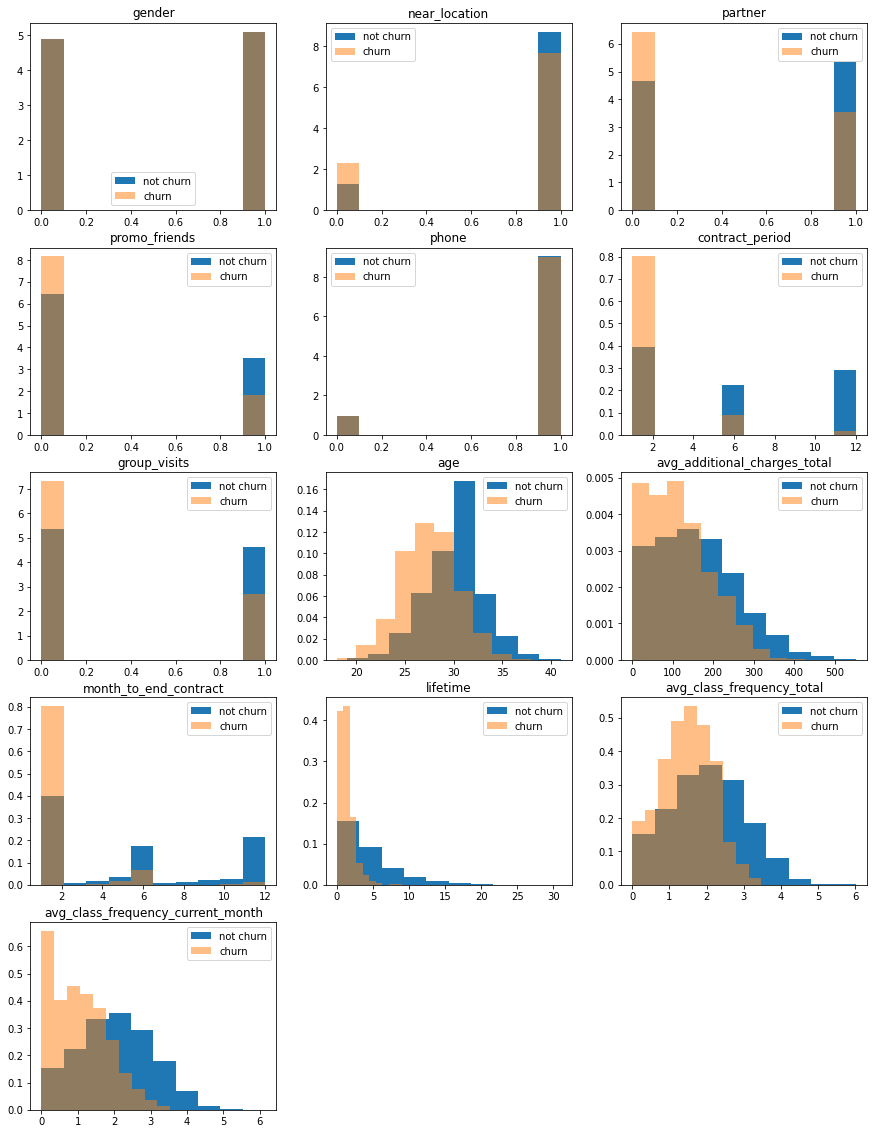

In [15]:
df_sign = df.drop('churn', axis = 1)

x = 5 # пять рядов графиков
y = 3 # три графика в ряду
y_ = 0
x_ = 0

fig, axes = plt.subplots(figsize=(15, 20))
for i in df_sign.columns:
    ax = plt.subplot2grid((x, y), (x_, y_))
    ax.hist(df.query('churn==0')[i], density=True, label = 'not churn')
    ax.hist(df.query('churn==1')[i], density=True, alpha=.5, label = 'churn')
    ax.set_title(i)
    ax.legend()
    y_ += 1
    
    if y_ == y:
        x_ += 1
        y_ = 0

Среди ушедших (отток) по сравнению с оставшимися больше тех, кто:
- живет дальше,
- не сотрудник компании-партнёра клуба,
- не использовал промо-код от знакомого при оплате первого абонемента,
- у кого длительность текущего действующего абонемента составляет 1 месяц,
- не посещает групповые занятия,
- младше,
- приносит меньше суммарной выручки от других услуг фитнес-центра,
- у кого срок до окончания текущего действующего абонемента составляет 1 месяц,
- у кого меньше время с момента первого обращения в фитнес-центр,
- у кого меньше средняя частота посещений в неделю за все время с начала действия абонемента,
- у кого меньше средняя частота посещений в неделю за предыдущий месяц.

### Матрица корреляций

Построю и отрисую матрицу корреляций.

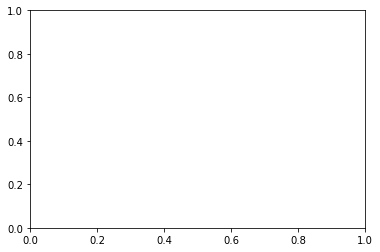

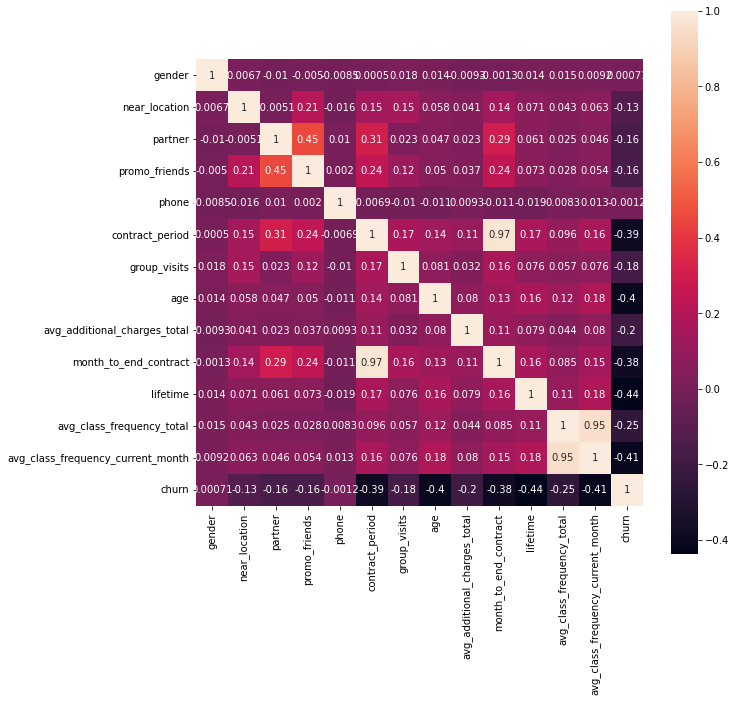

In [16]:
#вычисляю матрицу корреляций
cm = df.corr() 
fig, ax = plt.subplots()
plt.figure(figsize=(10,10))
#нарисую тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True);

Пять признаков сильнее остальных коррелируют с целевой переменной факта оттока клиентов. Это - длительность текущего действующего абонемента ,возраст клиента, срок до окончания текущего действующего абонемента, время с момента первого обращения в фитнес-центр и средняя частота посещений в неделю за предыдущий месяц.
Явных лидеров среди коррелирующих признаков нет.

Также наблюдается две пары мультиколлинеарных признаков:
- срок до окончания текущего действующего абонемента и длительность текущего действующего абонемента,
- средняя частота посещений в неделю за предыдущий месяц и  средняя частота посещений в неделю за все время с начала действия абонемента.
 
По одному признаку из каждой пары можно было бы удалить, чтобы не получить возможно нерепрезентативные веса. Но поскольку учебная задача проекта этого не требует, оставлю их.

**Выводы**



Проведен исследовательский анализ данных, по результатам которого выявлены следующие наблюдения:

27% клиентов ушло. Уходят чаще те, у кого небольшая длительность текущего абонемента, у кого осталось меньше 2 месяцев до конца абонемента, а срок с момента первого обращения составляет 1 месяц. Также в среднем те, кто уходят, занимаются не в рамках партнерской программы и не пришли по промо от друга, они в меньшей доле посещают групповые занятия, меньше тратят денег на другие услуги фитнес-центра, моложе, живут дальше, а также реже занимаются.

Пять признаков сильнее остальных коррелируют с целевой переменной факта оттока клиентов. Это - длительность текущего действующего абонемента ,возраст клиента, срок до окончания текущего действующего абонемента, время с момента первого обращения в фитнес-центр и средняя частота посещений в неделю за предыдущий месяц. Явных лидеров среди коррелирующих признаков нет.

[в начало](#start1)

## Модель прогнозирования оттока клиентов

Разобью данные на обучающую и валидационную выборки.

In [17]:
X = df.drop('churn', axis = 1)
y = df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Проверю количественный состав получившихся выборок.

In [18]:
for i in X_train, X_test, y_train, y_test:
    print(i.shape)

(3200, 13)
(800, 13)
(3200,)
(800,)


Все верно.

### Логистическая регрессия

Обучу модель на train-выборке логистической регрессией.

In [19]:
# задам алгоритм для модели
model_lr = LogisticRegression(solver='liblinear',  random_state=0)
 
# обучу модель
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [20]:
predictions_lr = model_lr.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_lr)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_lr)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_lr)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83


Доля правильных ответов составила 93%. Точность прогнозирования клиентов в группе оттока составила 86% и у показателя полноты нахождения всех клиентов, которые оказались в оттоке, показатель на уровне 83%.  

Посмотрю на коэффициенты для каждого признака.

In [21]:
pd.DataFrame(columns=['coefficient'], 
             data = model_lr.coef_[0].round(3), 
             index = X.columns)

,coefficient
gender,0.059
near_location,0.021
partner,-0.053
promo_friends,-0.495
phone,0.563
contract_period,-0.174
group_visits,-0.687
age,-0.176
avg_additional_charges_total,-0.005
month_to_end_contract,-0.082


В модели логистической регрессии наиболее значимыми признаками стали:
- средняя частота посещений в неделю за предыдущий месяц,
- средняя частота посещений в неделю за все время с начала действия абонемента. 

### Случайный лес

Обучу модель на train-выборке случайным лесом.

In [22]:
# задам алгоритм для модели
model_rf = RandomForestClassifier(random_state = 0) 
# обучу модель
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [23]:
predictions_rf = model_rf.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_rf)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_rf)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_rf)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


При оптимальном количестве деревьев доля правильных ответов составила 92%, данная модель также неплохо справляется с предсказаниями. Точность прогнозирования клиентов в группе оттока составила 84%, а вот полнота нахождения всех клиентов, которые оказались в оттоке, только 82%.

In [24]:
pd.DataFrame(columns=['coefficient'], 
             data = model_rf.feature_importances_.round(3), 
             index = X.columns)

,coefficient
gender,0.012
near_location,0.009
partner,0.012
promo_friends,0.012
phone,0.006
contract_period,0.066
group_visits,0.016
age,0.119
avg_additional_charges_total,0.091
month_to_end_contract,0.069


В модели случайного леса наиболее значимыми признаками стали:
- время с момента первого обращения в фитнес-центр,
- средняя частота посещений в неделю за предыдущий месяц,
- средняя частота посещений в неделю за все время с начала действия абонемента.

**Выводы**

Модель логической регрессии оказалась чуть лучше по всем метрикам.

В модели логистической регрессии наиболее значимыми признаками стали:

- средняя частота посещений в неделю за предыдущий месяц,
- средняя частота посещений в неделю за все время с начала действия абонемента.

В модели случайного леса наиболее значимыми признаками стали:

- время с момента первого обращения в фитнес-центр,
- средняя частота посещений в неделю за предыдущий месяц,
- средняя частота посещений в неделю за все время с начала действия абонемента.

[в начало](#start1)

## Кластеризация клиентов

### Стандартизация данных

In [25]:
scaler = StandardScaler()
# обучу и стандартизирую данные методом transform scaler 
X_sс = scaler.fit_transform(X) 

### Матрица расстояний и дендрограмма

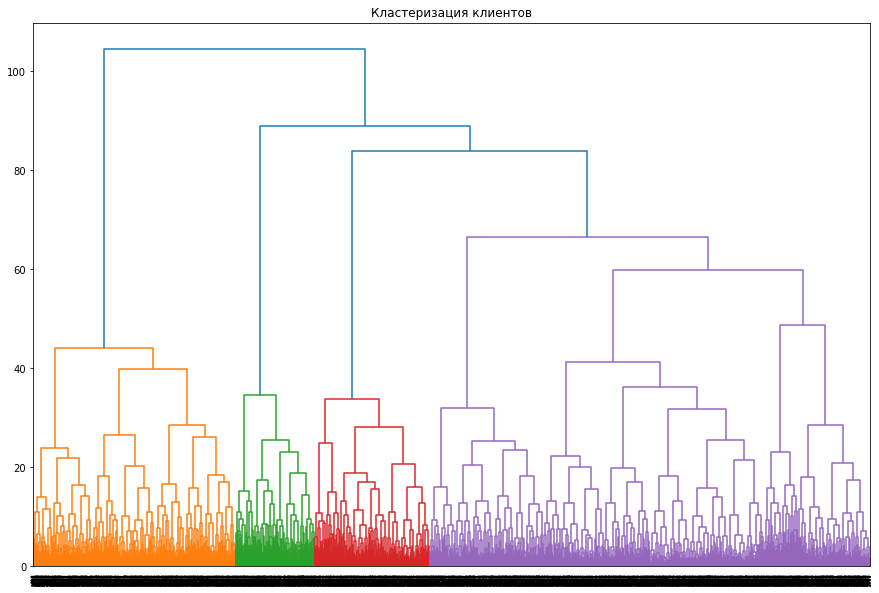

In [26]:
linked = linkage(X_sс, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

### K-Means

Обучу модель кластеризации на основании алгоритма K-Means и спрогнозирую кластеры клиентов. 

In [27]:
# задаю число кластеров, равное 5, и фиксирую значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)
# применяю алгоритм к данным и формирую вектор кластеров
labels = km.fit_predict(X_sс)
# сохраняю метки кластера в датасете
df['cluster_km'] = labels
# вывожу статистику по средним значениям признаков по кластерам
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Посмотрю на размерность кластеров.

In [28]:
df.cluster_km.value_counts().sort_index()

0    1010
1     385
2     505
3    1262
4     838
Name: cluster_km, dtype: int64

Получилось 3 крупных кластера размером 1262, 1010 и 838 клиентов, а также 2 более мелких размером 505 и 385 клиентов.  
В сформированных кластерах наблюдается следующая картина:
- кластеры не равнозначны по количеству клиентов и по доле оттока,
- в самом объемном кластере (3) самый высокий отток, также к оттоку склонны кластеры 2 и 1, самый надежный кластер 0,
- бОльший отток у клиентов с самой низкой длительностью текущего действующего абонемента - чуть менее 2х месяцев,
- в кластере с бОльшим оттоком мало сотрудников компании-партнёра клуба и мало пришедших по рекомендации друзей, один из низких показателей участия в групповых занятиях, возраст 28 лет, меньше всего расходов на доп.услуги, меньший срок до окончания абонемента, ниже всего время с момента первого посещения и ниже всего средняя частота посещений в неделю и за весь период.


### Распределение признаков для кластеров

#### Бинарные признаки

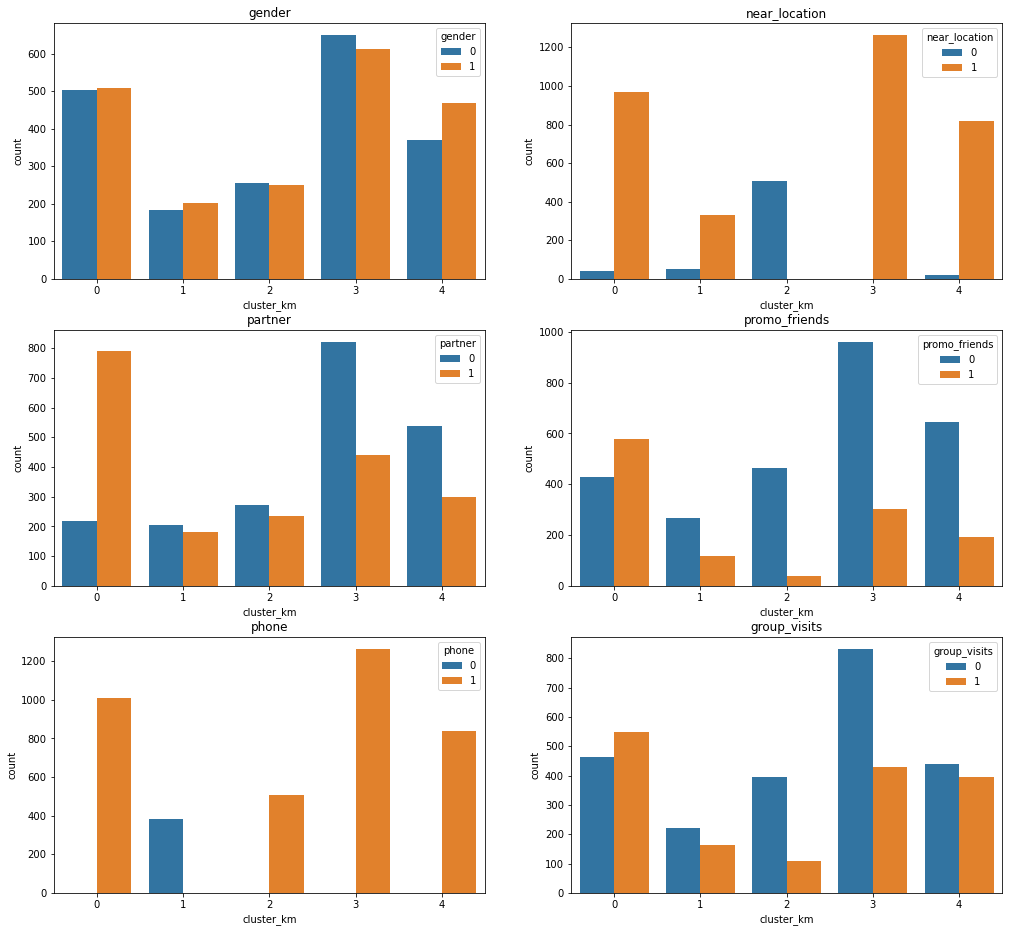

In [29]:
x = 3 
y = 2 
y_ = 0
x_ = 0

fig, axes = plt.subplots(x, y, figsize=(17, 16))
for i in ['gender', 
          'near_location', 
          'partner', 
          'promo_friends',
          'phone', 
          'group_visits']:
    sns.countplot(data = df, x='cluster_km', hue=i, ax=axes[x_, y_])
    axes[x_, y_].set_title(i)
    y_ += 1
    
    if y_ == y:
        x_ += 1
        y_ = 0

- гендерное распределение в кластерах одинаково,
- кластеры 0, 3 и 4 - живущие близко к фитнес-клубу,
- кластер 0 - в основном, сотрудники компании-партнёра клуба, кластеры 3 и 4 - больше не сотрудников, 
- кластеры 1, 2, 3 и 4 - в основном, клиенты, пришедшие без рекомендации друзей и знакомых,
- кластер 1 - нет номера телефона, в остальных есть,
- кластеры 2 и 3 - в большинстве своем не посещают групповые занятия.

#### Числовые и категориальные небинарные признаки 

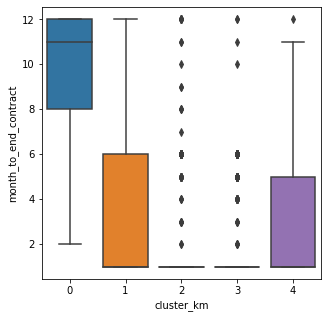

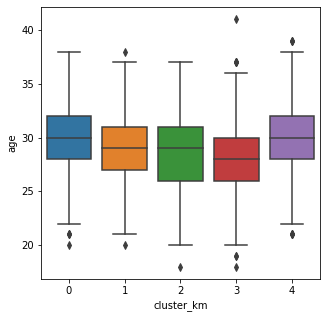

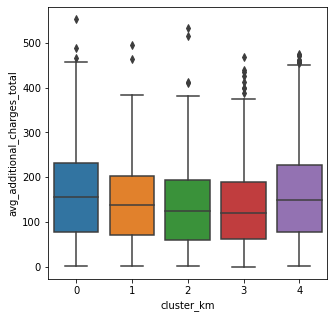

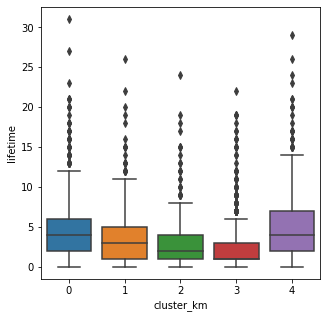

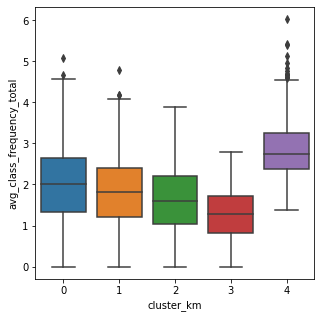

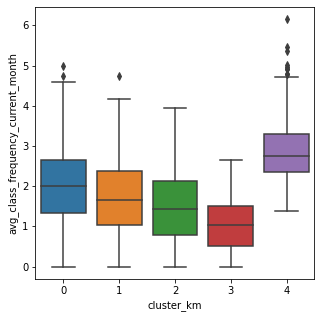

In [30]:
for column in [
    'month_to_end_contract',
    'age',
    'avg_additional_charges_total',
    'lifetime',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster_km', y = df[column], data = df)
    plt.show()

- кластеры 2 и 3 - 1 месяц  до окончания текущего действующего абонемента,
- кластеры 1, 2 и особенно 3 - меньший возраст,
- кластеры 0 и 4 - больше доп.трат,
- кластер 3 -  меньшее время с момента первого посещения,
- кластер 4 - высокая частота посещений в неделю за последний месяц и весь период, кластер 3 - эти показатели низкие.

**Выводы**

На основе отрисованной дендрограммы выделено 4 кластера.

Обучена модель кластеризации на основании алгоритма K-Means и спрогнозированы 5 кластеров:

Получилось 3 крупных кластера размером 1262, 1010 и 838 клиентов, а также 2 более мелких размером 505 и 385 клиентов.

В сформированных кластерах наблюдается следующая картина:

кластеры не равнозначны по количеству клиентов и по доле оттока,
в самом объемном кластере (3) самый высокий отток, также к оттоку склонен кластер 2, самый надежный кластер 0,
бОльший отток у клиентов с самой низкой длительностью текущего действующего абонемента - чуть менее 2х месяцев,
в кластере с бОльшим оттоком мало сотрудников компании-партнёра клуба и мало пришедших по рекомендации друзей, один из низких показателей участия в групповых занятиях, возраст 28 лет, меньше всего расходов на доп.услуги, меньший срок до окончания абонемента, ниже всего время с момента первого посещения и ниже всего средняя частота посещений в неделю и за весь период.

[в начало](#start1)

## Выводы


Идеальный клиент для сети фитнес-центров «Культурист-датасаентист» это:

- возраст 30 лет,
- сотрудник компании-партнера,
- пришел в фитнес-центр по рекомендации друзей/знакомых,
- с высокой длительностью текущего абонемента (в идеале 12 мес.),
- является клиентом около 5 мес. (подтвердил на деле серьезность намерений держать себя в форме),
- посещает групповые занятия,
- не менее 2х раз в неделю посещает фитнес-центр,
- в среднем тратит 161 у.е. в месяц на доп.услуги фитнес-центра.

Рекомендации для привлечения клиентов:

- активно использовать акцию «приведи друга»: клиенты с бОльшей вероятностью ходят на занятия за компанию,
- в рекламе фитнес-центра делать акцент на потребности возрастной группы +- 30 лет,
- развивать сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент,
- предлагать клиентам абонементы на длительный срок (12 мес.)

Рекомендации для удержания клиентов:

- необходимо предлагать разнообразный спектр групповых занятий,
- давать большее распространение акции "приведи друга",
- расширять предложения доп.услуг внутри клуба,
- стимулировать покупку абонементов максимальной длительности (12 мес.),
- собирать обратную связь и вносить улучшения по значимым моментам.

[в начало](#start1)